# Implementation of MutiClass Logistic Regression using Tensorflow core

- The TensorFlow Core APIs provide access to low level functionality within the TensorFlow ecosystem. This API provides more flexibility and control for building ML models, applications, and tools, compared to high-level APIs, such as Keras.

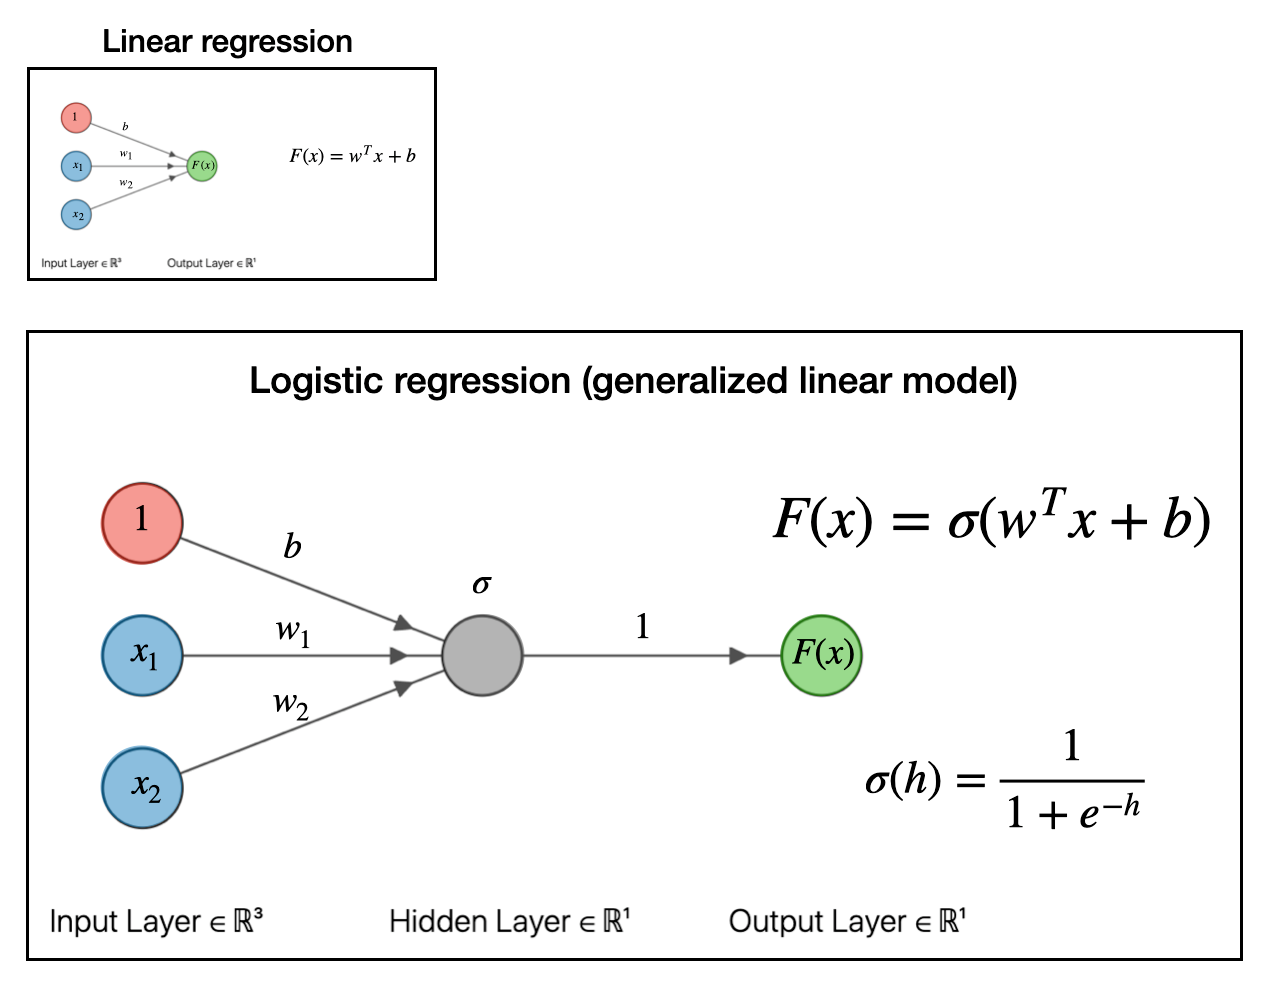

### Logistic regression with input and output shape
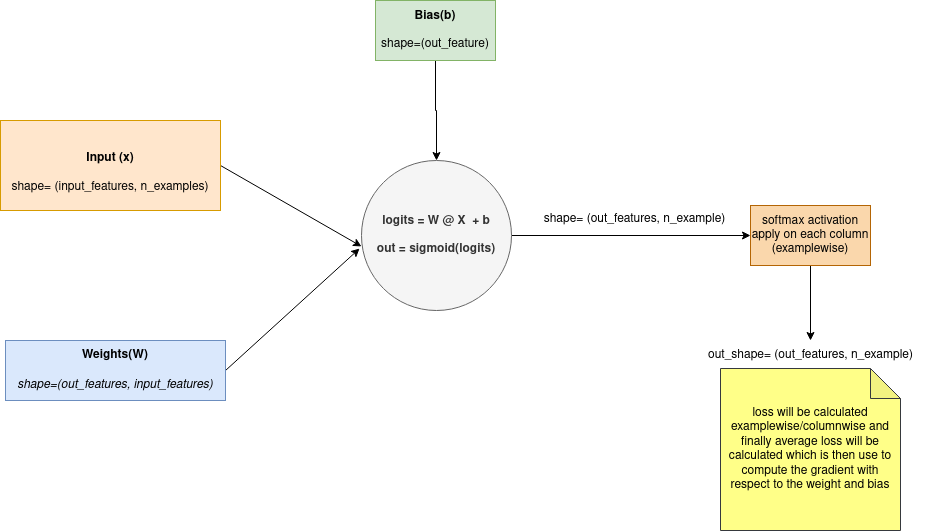

In [1]:
# !pip install pandas

In [169]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [176]:
# We are setting this random seed inorder to get persistent result while generating random numbers
SEED = 40
tf.random.set_seed(SEED)

In [177]:
tf.random.normal((1,2))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-1.0998507 ,  0.06154116]], dtype=float32)>

**expected_out** = <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.07676513, -0.2082602 ]], dtype=float32)>

**Note**: If you re-execute the tf.random.number() the result will be changed, but if you execut it after execution of the above random.set_seed() statiment, you will always get the same result.

## Load the Data
We will be using MNIST dataset. In future, we will prepare dataset using various methods.

In [178]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [179]:
print("x_train shape: ",x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


In [180]:
NUM_CLASSES = len(np.unique(y_train))
print(f"There are {NUM_CLASSES} unique classes in this dataset")

There are 10 unique classes in this dataset


In [181]:
def show_data(index, x, y):
    plt.figure(figsize=(20,4))
    for i in range(index, index+5):
        img = x[i]
        label = y[i]
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title('Training: %i\n' % label, fontsize = 15);

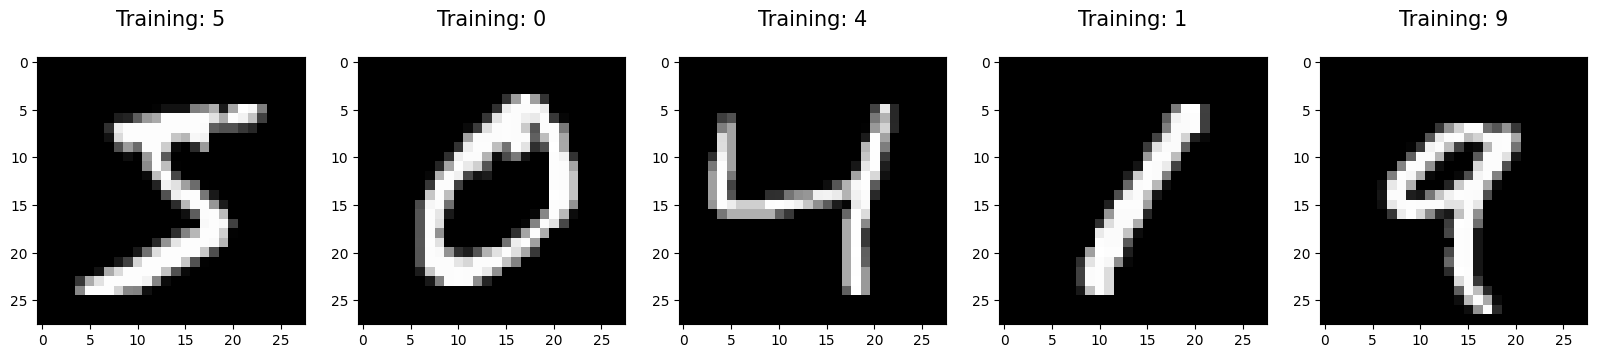

In [182]:
show_data(0, x_train, y_train)

# Preprocess the data

- Since, We are not using convolution neural network, we will be treating each pixel as input feature. So for 28X28 image, there will be 28\*28 = 784 input features.
- So in comparision with above diagram we have input(X) shape = (input_features, n_examples) = (784, 60000)

In [183]:
x_train = tf.reshape(x_train, shape=(x_train.shape[0], -1))
x_test = tf.reshape(x_test, shape=(x_test.shape[0], -1))

In [184]:
x_train.shape, x_test.shape

(TensorShape([60000, 784]), TensorShape([10000, 784]))

Now let's apply transpose operation to the metrix so the we have (784, 60000) shape.

In [185]:
x_train = tf.cast(tf.transpose(x_train), "float32")
x_test = tf.cast(tf.transpose(x_test), "float32")
y_train = tf.constant(y_train)
print("New x_train shape: ", x_train.shape)
print("New x_test shape: ", x_test.shape)

New x_train shape:  (784, 60000)
New x_test shape:  (784, 10000)


In [189]:
# Normalization 
class Normalize(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
    def norm(self, x):
        # normalize the input image
        return x / 255.
    def denorm(self, x):
        return x*255.

In [190]:
norm_x = Normalize()
normalized_x = norm_x.norm(x_train[:, 0])

In [191]:
tf.math.reduce_all(tf.equal(x_train[:, 0], norm_x.denorm(normalized_x))).numpy()

True

**tf.math.reduce_all()** is a TensorFlow function used to compute the logical AND reduction of elements in a tensor along the specified axes.

It confirms that the both the original x and denormalized after normalizing x are equal. 

In [192]:
x_train = norm_x.norm(x_train)
x_test = norm_x.norm(x_test)

## Softmax Activation Function
The softmax activation function is a commonly used activation function in the output layer of a neural network for multi-class classification tasks. It converts raw class scores (logits) into normalized probabilities, making it suitable for problems where an input can belong to one of multiple exclusive classes.

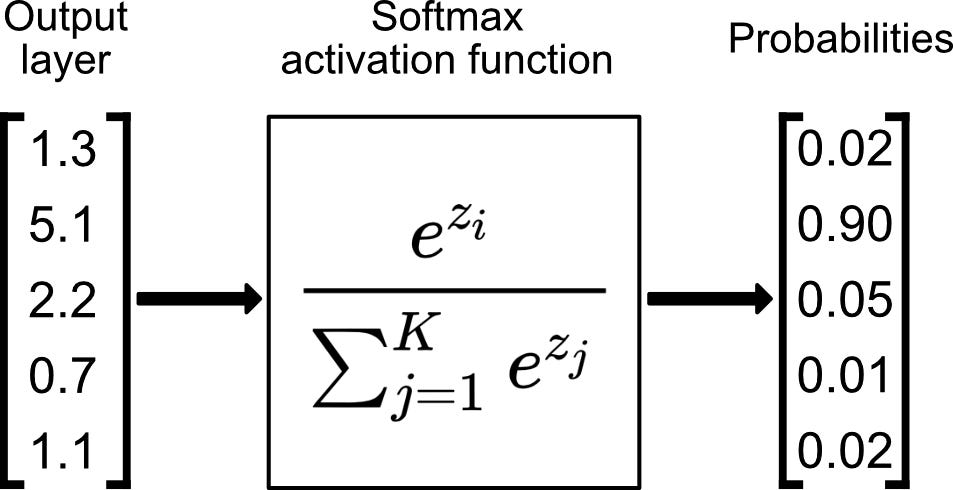

In [193]:
def softmax(x):
#     x shape --> (num_features, num_examples)
    ex_x = tf.math.exp(x)
    sum_ex = tf.reduce_sum(ex_x, axis=0)
    softmax_x = ex_x / sum_ex
    return softmax_x

In [194]:
x = tf.constant([[1.3],
                 [5.1],
                 [2.2],
                 [0.7],
                 [1.1]])
softmax_x = softmax(x)
print("Softmax of x: ", softmax_x)
# we can verify whether our softmax function is working fine or not by simpling adding value for axis=0, it should be 1
print(" Verification of softmax: ", tf.reduce_sum(softmax_x, axis=0))

Softmax of x:  tf.Tensor(
[[0.02019047]
 [0.9025377 ]
 [0.04966054]
 [0.01108076]
 [0.01653056]], shape=(5, 1), dtype=float32)
 Verification of softmax:  tf.Tensor([1.], shape=(1,), dtype=float32)


In [195]:
tf.math.softmax(x, axis=0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.02019046],
       [0.90253764],
       [0.04966053],
       [0.01108076],
       [0.01653055]], dtype=float32)>

## Sigmoid Activation Function

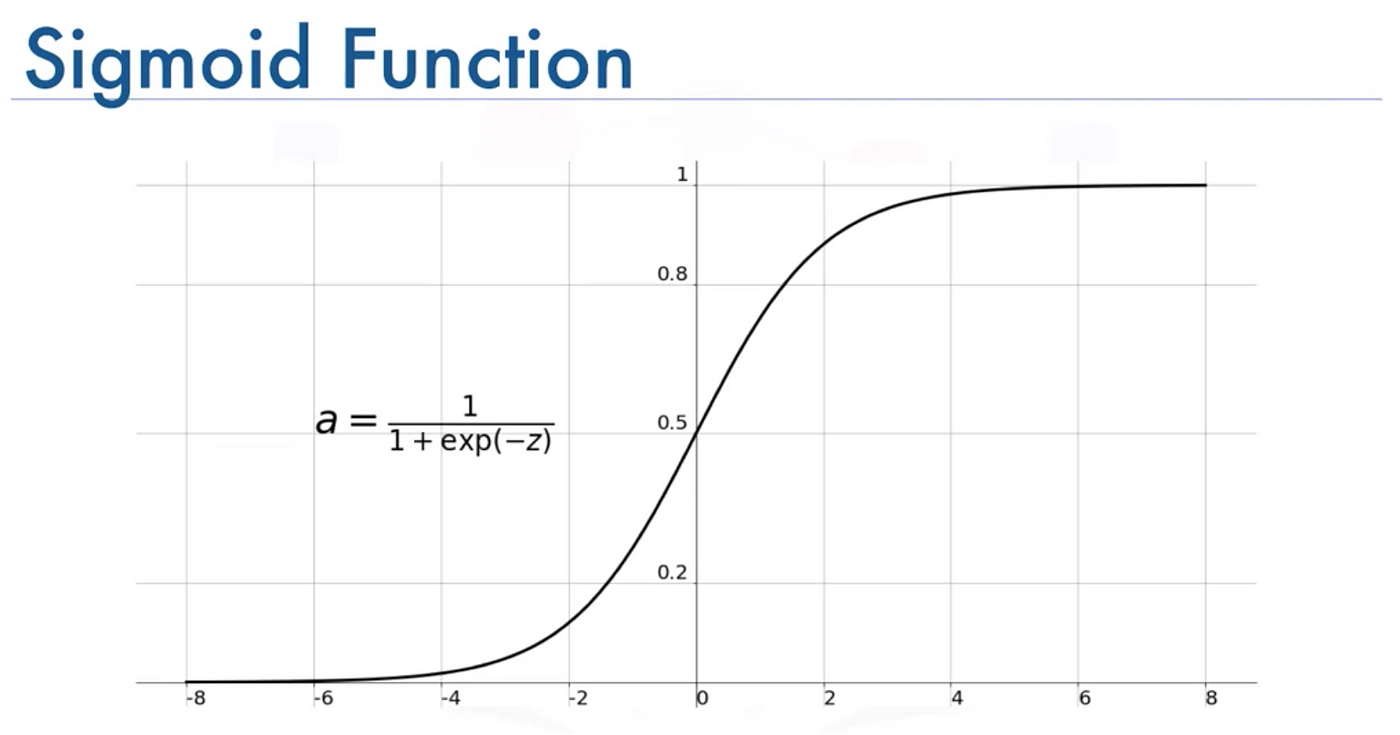

In [196]:
def sigmoid(z):
    exp_z = tf.math.exp(-z)
    return 1 / (1 + exp_z)

In [197]:
x = tf.constant([[0.9, 1.35, -1.3456],
                 [2.456, 3.987, 4.234]])

sigmoid(x), tf.math.sigmoid(x)

(<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[0.7109495 , 0.7941296 , 0.20659064],
        [0.9209991 , 0.98178273, 0.98571277]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[0.7109495 , 0.7941296 , 0.20659065],
        [0.9209991 , 0.98178273, 0.98571277]], dtype=float32)>)

## Custom Loss function
- **CrossEntropy Loss:**
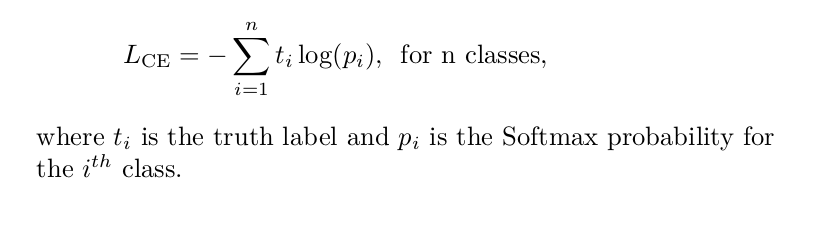

**Note:** In keras lossfunction API, there is this from_logits parameter,
 - **from_logits=True** means the input to crossEntropy layer is normal tensor/logits, 
 - **from_logits=False**, means the input is a probability and usually you should have some softmax activation in your last layer.

In [259]:
# since we will be applying softmax function in the last layer, we will use crossentroy loss withh from_logits = False
def sparse_categorical_crossentropy_loss(y_true, y_pred, from_logits=False):
    # Here  y_true shape --> (num_examples)
    # y_pred shape --> (out_class, num_examples)
    if from_logits:
        y_pred = softmax(y_pred)
        
    one_hot_y_true = tf.transpose(tf.one_hot(y_true, depth=y_pred.shape[0])) #here depth parameter takes number of features/classes
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    log_y_pred = tf.math.log(y_pred)
    mul = tf.multiply(one_hot_y_true, log_y_pred)    
    losses = -tf.reduce_sum(mul, axis=0)
    cost = tf.reduce_mean(losses, axis=-1)
    return cost

In [260]:
y_true = tf.constant([0, 1])
y_pred = tf.constant([[1., 0.],
                      [0., 1.]])

sparse_categorical_crossentropy_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1920929e-07>

In [261]:
tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, axis=0))

<tf.Tensor: shape=(), dtype=float32, numpy=1.1920928e-07>

In [262]:
y_true = tf.constant([0, 1])
y_pred = tf.constant([[0.6, 0.02],
                      [0.4, 0.98]])

sparse_categorical_crossentropy_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.26551414>

In [263]:
tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, axis=0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.26551414>

## Model Building 

Multiclass logistic regression, also known as softmax regression, is a type of classification algorithm used to classify input data into multiple exclusive classes. It is an extension of binary logistic regression, which is used for binary classification tasks. Multiclass logistic regression is particularly useful when you have more than two classes in your classification problem.

In [264]:
def relu(x):
    return tf.maximum(0., x)

In [265]:
relu(tf.constant([-1., 0.5, 10.]))

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0. ,  0.5, 10. ], dtype=float32)>

In [266]:
class MultiClassLogisticRegression(tf.Module):
    def __init__(self, n_classes, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.is_built = False
        self.n_class = n_classes
    
    def build(self, num_features):
        # randomly generate bias and weights
        self.weights = tf.Variable(tf.random.normal([self.n_class, num_features]))
        self.bias = tf.Variable(tf.zeros([self.n_class, 1]))
    
    def predict(self, x):
        #compute model output
        # compute logits
        logits = self.weights @ x + self.bias
        sigmoid_out = sigmoid(logits)
        return softmax(sigmoid_out)
    
    def __call__(self, x):
        if not self.is_built:
            self.build(x.shape[0])
            self.is_build = True
        return self.predict(x)

In [267]:
x_train_sample = x_train[:, :20]
y_train_sample = y_train[:20]
x_train_sample.shape, y_train_sample.shape

(TensorShape([784, 20]), TensorShape([20]))

In [268]:
model = MultiClassLogisticRegression(10)
output = model(x_train_sample)
output.shape, output[:, 0]

(TensorShape([10, 20]),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.06695342, 0.0669536 , 0.07165678, 0.06699137, 0.18199182,
        0.066953  , 0.06695321, 0.16226302, 0.06826187, 0.18102185],
       dtype=float32)>)

## Accuracy Metrics


In [269]:
def cal_accuracy(y_true, y_pred):
    y_pred = tf.cast(tf.argmax(y_pred), "int32")
    y_true = tf.cast(y_true, "int32")
    matches = tf.cast(tf.equal(y_true, y_pred), "float32")
    return tf.reduce_mean(matches)

## Fit Function

In [270]:
# defining training function
def train(model, x_train, y_train, learning_rate=0.01):
    loss = 0
    with tf.GradientTape() as tape:
        y_pred = model(x_train)
        acc = cal_accuracy(y_train, y_pred)
        loss = sparse_categorical_crossentropy_loss(y_train, y_pred)
        
    dw, db = tape.gradient(loss, [model.weights, model.bias])
    # applying gradient descent 
    # w = w - lr * dloss/dw
    model.weights.assign_sub(learning_rate * dw)
    model.bias.assign_sub(learning_rate * db)
    return loss, acc

In [271]:
train(model, x_train_sample, y_train_sample, learning_rate=0.01)

(<tf.Tensor: shape=(), dtype=float32, numpy=2.368456>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.1>)

In [272]:
def display_training_summary(loss, accuracy, epoch):
    print(f"EPOCH: {epoch} --- loss: {loss}---accuracy: {accuracy}")

In [273]:
# sample train data
x_train_sample = x_train[:, :60_000]
y_train_sample = y_train[:60_000]

x_train_sample.shape, y_train_sample.shape

(TensorShape([784, 60000]), TensorShape([60000]))

In [274]:
#model initiate
model = MultiClassLogisticRegression(NUM_CLASSES)

LOSS_HISTORY = []
ACC_HISTORY = []

In [279]:
NUM_EPOCHS = 10
LEARNING_RATE = 1

#  Training Loop
for epoch in range(NUM_EPOCHS):
    loss, acc = train(model, x_train_sample, y_train_sample, LEARNING_RATE)
    LOSS_HISTORY.append(loss)
    ACC_HISTORY.append(acc)
    display_training_summary(loss, acc, epoch+1)

EPOCH: 1 --- loss: 2.314143180847168---accuracy: 0.08730000257492065
EPOCH: 2 --- loss: 2.5044167041778564---accuracy: 0.06706666946411133
EPOCH: 3 --- loss: 2.3608691692352295---accuracy: 0.08449999988079071
EPOCH: 4 --- loss: 2.3941824436187744---accuracy: 0.09075000137090683
EPOCH: 5 --- loss: 2.4311892986297607---accuracy: 0.09273333102464676
EPOCH: 6 --- loss: 2.481031656265259---accuracy: 0.09361666440963745
EPOCH: 7 --- loss: 2.3786380290985107---accuracy: 0.08391666412353516
EPOCH: 8 --- loss: 2.3380355834960938---accuracy: 0.08926666527986526
EPOCH: 9 --- loss: 2.381716251373291---accuracy: 0.10040000081062317
EPOCH: 10 --- loss: 2.4216156005859375---accuracy: 0.1036333367228508


In [723]:
test_image = x_test[:, 10]
test_label = y_test[10]
test_image = tf.reshape(test_image, shape=(-1, 1))
test_image.shape

TensorShape([784, 1])

In [724]:
y_pred = model(test_image)
predicted_label = tf.argmax(y_pred, axis=0).numpy()[0]
predicted_label

8

In [725]:
test_label

0

In [726]:
test_img = tf.reshape(test_image, shape=(28, 28)).numpy()
test_img.shape

(28, 28)

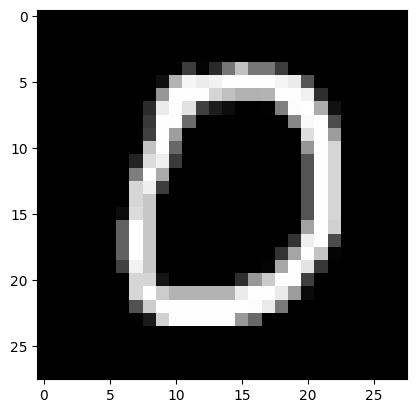

In [727]:
plt.imshow(test_img, cmap="gray")